In [2]:
filename = "baseline-16vCPUs-GAS-1.csv"

In [12]:
import json
import os
import wandb
from dotenv import load_dotenv
load_dotenv(override=True)
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("kubework/hivemind-parameter-averaging-resnet18-imagenet_scale-up", filters={
    "$and": [
        {"config.run_name": {"$regex": "baseline-*"}},
        {"summary_metrics.cpu/logical_core_count": 16},
        {"config.gradient_accumulation_steps": 1},
    ]
})
history_list = []
summary_list = []
config_list = []

for run in runs:
    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items()}
    config["optimizer_params.lr"] = config["optimizer_params"]["lr"]
    config["optimizer_params.momentum"] = config["optimizer_params"]["momentum"]
    config_list.append(config)

    history = run.scan_history(keys=[
        "_timestamp",
        "train/step",
        "bandwidth/net_recv_sys_bandwidth_mbs",
        "bandwidth/net_sent_sys_bandwidth_mbs",
        "train/samples_ps",
        "train/data_load_s",
        "train/model_forward_s",
        ("train/model_backward_only_s" if "train/model_backward_only_s" in run.summary._json_dict else "train/model_backward_s"),
        *(["train/model_opt_s"] if "train/model_backward_only_s" in run.summary._json_dict else []),
    ])
    history_tmp = []
    sum_total_time_s = 0
    sum_missing_time_s = 0
    for row in history:
        total_time_s = config["batch_size_per_step"] / row["train/samples_ps"]
        missing_time_s = total_time_s - row["train/data_load_s"] - row["train/model_forward_s"]
        # for old runs incorporating both...
        if "train/model_backward_only_s" in row:
            missing_time_s -= row["train/model_backward_only_s"] - row["train/model_opt_s"]
        else:
            missing_time_s -= row["train/model_backward_s"]
        sum_total_time_s += total_time_s
        sum_missing_time_s += missing_time_s
        history_tmp.append({**row, **config, "name": run.name, "train/total_time_s": total_time_s, "train/missing_time_s": missing_time_s})
    history_list.extend(history_tmp)
    summary_list.append({
        **run.summary._json_dict,
        "train/total_time_s": sum_total_time_s / len(history_tmp),
        "train/missing_time_s": sum_missing_time_s / len(history_tmp),
    })

import pandas as pd 
history_df = pd.DataFrame.from_records(history_list) 
all_df = pd.concat([history_df], axis=1)
all_df.to_csv(filename)

config_df = pd.DataFrame.from_records(config_list) 
summary_df = pd.DataFrame.from_records(summary_list)
all_df = pd.concat([config_df, summary_df], axis=1)
all_df.to_csv(f"summary-{filename}")

/home/adi/Workspace/TUM/TUMThesis/viz/venv/lib/python3.8/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


<Figure size 1200x800 with 0 Axes>

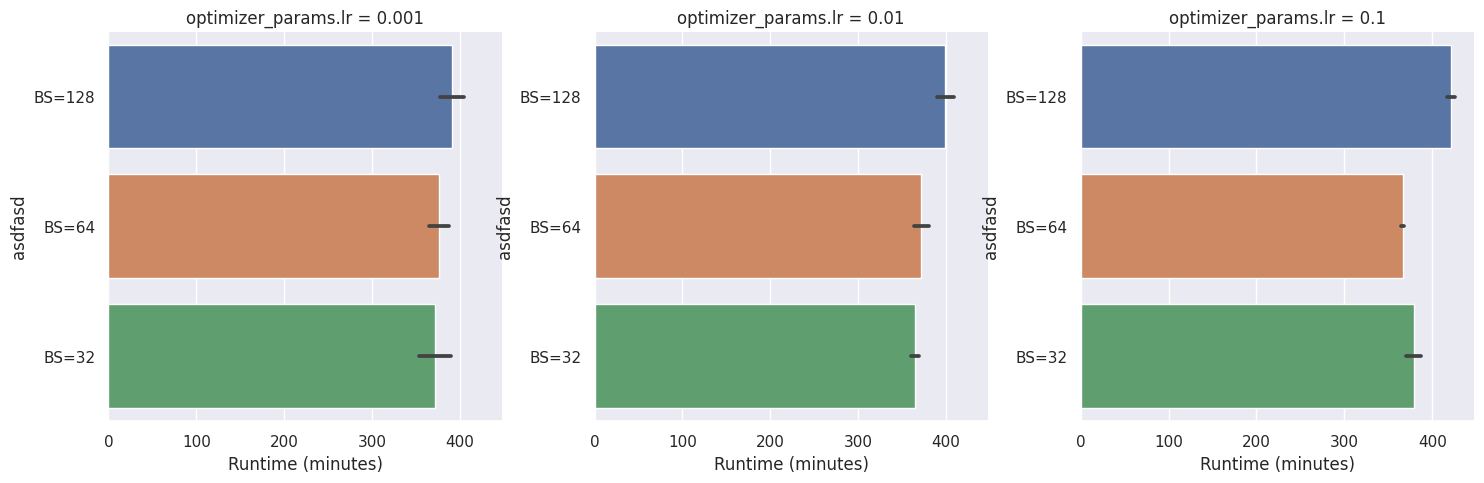

       Unnamed: 0  epochs  max_steps  initial_peers  log_frequency  \
count   12.000000    12.0       12.0            0.0           12.0   
mean    29.500000     1.0    10000.0            NaN            1.0   
std      3.605551     0.0        0.0            NaN            0.0   
min     24.000000     1.0    10000.0            NaN            1.0   
25%     26.750000     1.0    10000.0            NaN            1.0   
50%     29.500000     1.0    10000.0            NaN            1.0   
75%     32.250000     1.0    10000.0            NaN            1.0   
max     35.000000     1.0    10000.0            NaN            1.0   

       number_of_nodes  matchmaking_time  averaging_timeout  \
count             12.0               0.0                0.0   
mean               1.0               NaN                NaN   
std                0.0               NaN                NaN   
min                1.0               NaN                NaN   
25%                1.0               NaN              

In [52]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
data["_runtime"] = data["_runtime"] / 60
data["run_name"] = data.apply(lambda row: f"BS={row['batch_size_per_step']}", axis=1)

fig = plt.figure()

ax = sns.catplot(data, kind="bar", x='_runtime', y='run_name', col="optimizer_params.lr", errorbar="sd", dodge=False, orient="h", sharey=False)

ax.set(xlabel='Runtime (minutes)', ylabel="asdfasd")

fig = plt.gcf()
fig.savefig(f"../../figures/06_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
plt.show()

/home/adi/Workspace/TUM/TUMThesis/viz/venv/lib/python3.8/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


<Figure size 640x480 with 0 Axes>

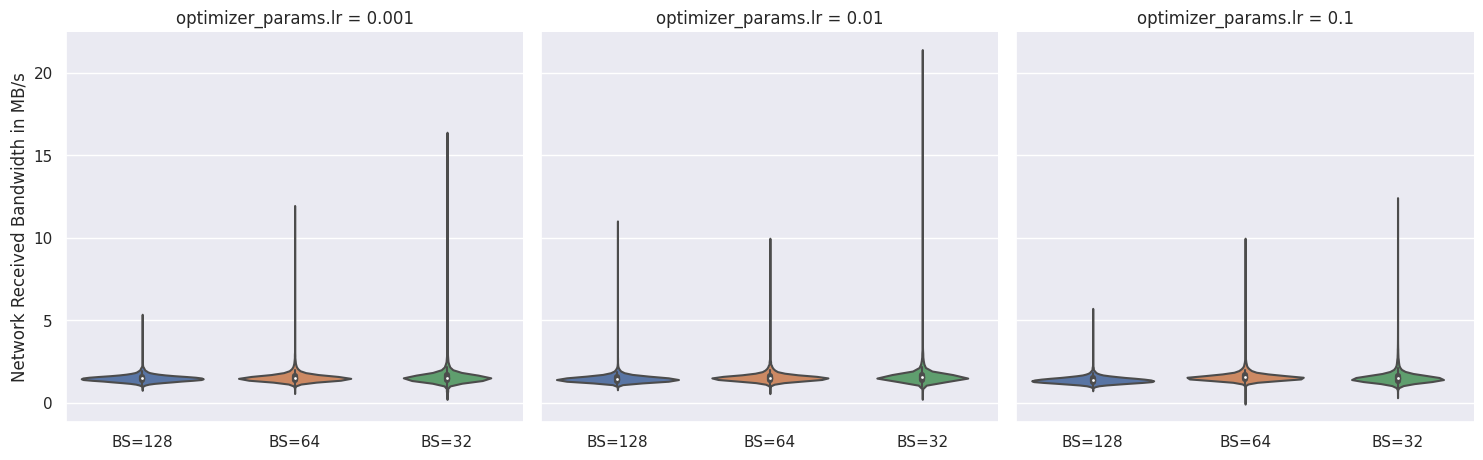

In [31]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv(os.path.abspath('') + f"/{filename}")
data["run_name"] = data.apply(lambda row: f"BS={row['batch_size_per_step']}", axis=1)

fig = plt.figure()

# sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.catplot(data, x="run_name", y="bandwidth/net_recv_sys_bandwidth_mbs", kind="violin", col="optimizer_params.lr", dodge=False, sharex=False)
# ax = sns.boxplot(data, )

ax.set(xlabel='', ylabel='Network Received Bandwidth in MB/s')

fig = plt.gcf()
fig.savefig(f"../../figures/06_net-recv_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')

/home/adi/Workspace/TUM/TUMThesis/viz/venv/lib/python3.8/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


<Figure size 1200x800 with 0 Axes>

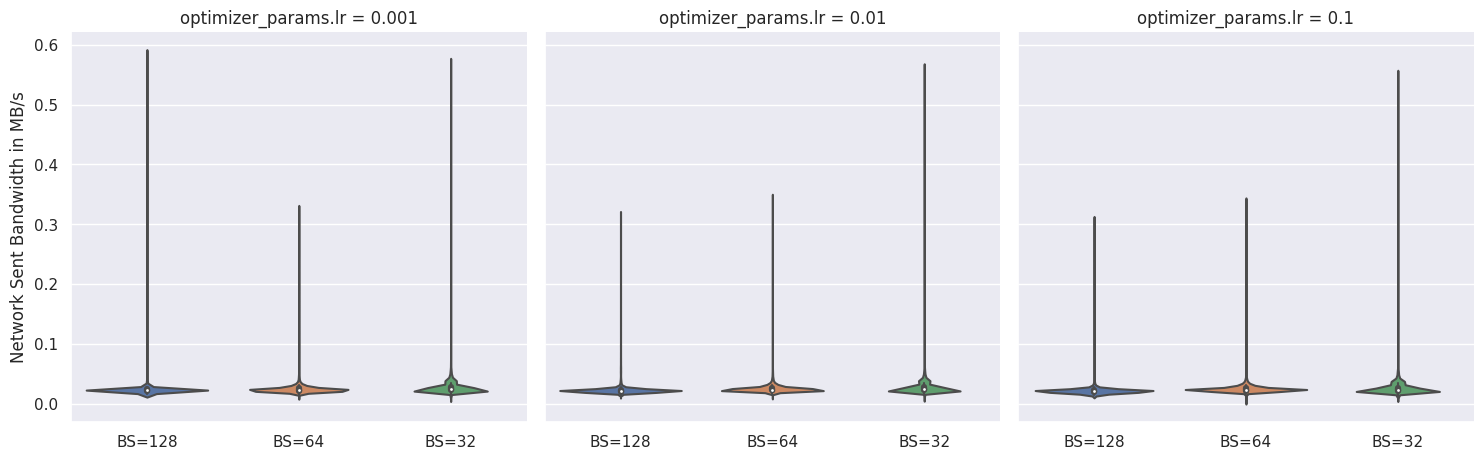

In [58]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv(os.path.abspath('') + f"/{filename}")
data["run_name"] = data.apply(lambda row: f"BS={row['batch_size_per_step']}", axis=1)

fig = plt.figure()

# sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.catplot(data, x="run_name", y="bandwidth/net_sent_sys_bandwidth_mbs", kind="violin", col="optimizer_params.lr", dodge=False, sharex=False)
# ax = sns.boxplot(data, )

ax.set(xlabel='', ylabel='Network Sent Bandwidth in MB/s')

fig = plt.gcf()
fig.savefig(f"../../figures/06_net-sent_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')

In [168]:
import os
import pandas as pd

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
data["_runtime"] = data["_runtime"] / 60

to_keep = ["max_steps", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps"]
data = data.sort_values(
    to_keep,
    ascending=[False, True, True, True]
)
data = data.groupby(by=to_keep)["_runtime"].describe().reset_index()

latex_output = []

for _, row in data.iterrows():
    max_steps = int(row['max_steps'])
    batch_size_per_step = int(row['batch_size_per_step'])
    lr = row['optimizer_params.lr']
    gas = int(row['gradient_accumulation_steps'])
    mean = round(row["mean"], 2)
    std = round(row["std"], 2)
    latex_output.append(f"{max_steps} & {batch_size_per_step} & {lr} & {gas} & {mean} ($\\pm {std}$) \\\\")
    latex_output.append("\\hline")

latex_output = "\n".join(latex_output)
with open(f"../../figures/06_summary-{filename.replace('.csv', '.tex')}", "w+") as f:
    f.write(latex_output)


In [6]:
import os
import pandas as pd

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
data["_runtime"] = data["_runtime"] / 60

data = data.sort_values(by=["max_steps", "optimizer_params.lr", "gradient_accumulation_steps"])
runtime_data = data.groupby(
    ["batch_size_per_step", "optimizer_params.lr", "max_steps", "gradient_accumulation_steps"]
)[
    "train/total_time_s", "train/missing_time_s",
    "train/samples_ps", "train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"
].describe().reset_index()
latex_output = []

for i, row in runtime_data.iterrows():
    max_steps = int(row['max_steps'])
    batch_size_per_step = int(row['batch_size_per_step'])
    lr = row['optimizer_params.lr']
    gas = int(row['gradient_accumulation_steps'])
    total_time_s_mean = row["train/total_time_s"]["mean"]
    train_s_mean = batch_size_per_step / row["train/samples_ps"]['mean']
    data_load_s_mean = round(row["train/data_load_s"]['mean'], 2)
    model_forward_s_mean = round(row["train/model_forward_s"]['mean'], 2)
    model_backward_only_s_mean = round(row["train/model_backward_only_s"]['mean'], 2)
    model_opt_s_mean = round(row["train/model_opt_s"]['mean'], 2)
    summed_total_s = data_load_s_mean + model_forward_s_mean + model_backward_only_s_mean + model_opt_s_mean

    print({
        total_time_s_mean,
    })
    

{2.222300463632018}
{2.1807395589924154}
{2.266113497141811}
{4.507094576102909}
{4.451506741819989}
{4.382909218615753}
{9.354188206767699}
{9.56176089899511}
{10.098819154924486}


/tmp/ipykernel_379/4221066979.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  runtime_data = data.groupby(


In [138]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv(os.path.abspath('') + f"/{filename}")
data = data[data["run_name"] == "baseline-80"]
data["_timestamp_date"] = pd.to_datetime(data["_timestamp"], unit="s")
data = data[["run_name", "_timestamp", "_timestamp_date", "train/total_time_s", "train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"]]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
summary_data["_runtime"] = summary_data["_runtime"] / 60

previous_timestamp = None

missing_time_list = []
for index, row in data.iterrows():
    if previous_timestamp == None:
        previous_timestamp = row["_timestamp"]
        continue
    missing_time_s = row["_timestamp"] - previous_timestamp
    missing_time_list.append({"train/real_time_s": missing_time_s})
    print(missing_time_s, row["train/total_time_s"])
    previous_timestamp = row["_timestamp"]



# summed = data.groupby(by=["run_name"])["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"].sum().reset_index().drop(["run_name"], axis=1)
# summed

# summary_data.groupby("run_name")["_runtime"].mean().reset_index()["_runtime"]
# summed.div(summary_data.groupby("run_name")["_runtime"].mean().reset_index()["_runtime"], axis=0) * 10

10 9.92450904699217
11 10.55102514300961
11 10.78853007699945
10 9.974933181001688
9 9.769773406005696
11 10.095001829002284
9 9.875298897997707
10 9.479090932989491
10 9.66229523900256
9 9.26410598300572
10 9.758708301000295
10 10.008386526998947
10 10.806085953998265
10 9.701042607994168
10 9.586468966997929
11 11.130228319001615
10 10.232641908994992
10 9.721588681000869
9 9.54198686100426
10 9.21452022800804
10 9.948786559005384
11 10.932002874993486
9 9.370422567008063
9 9.12426831999619
9 9.43137663199741
10 9.477266653004335
9 9.06213803301216
9 9.219743048000964
10 9.598816712998088
10 10.616297161002876
11 10.164264264996746
10 9.93038970399357
9 9.479894244010213
10 9.496413123997629
9 9.41198847600026
10 10.233458796996274
10 10.109989623000727
12 11.852255709003655
10 9.463352392005618
9 9.662458632999916
10 9.389786610990996
9 9.564078399998834
10 10.211934494989691
10 9.681373289000476
9 9.24318460500217
10 9.423525032005273
9 9.04762560800009
9 9.557073061005212
10 9.689